In [1]:
!pip install ultralytics opencv-python tqdm

  Using cached ultralytics-8.3.222-py3-none-any.whl.metadata (37 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached torch-2.9.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.24.0-cp313-cp313-win_amd64.whl.metadata (5.9 kB)
  Using cached polars-1.34.0-py3-none-any.whl.metadata (10 kB)
  Using cached ultralytics_thop-2.0.18-py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached polars_runtime_32-1.34.0-cp39-abi3-win_amd64.whl.metadata (1.5 kB)
Using cached ultralytics-8.3.222-py3-none-any.whl (1.1 MB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached torch-2.9.0-cp313-cp313-win_amd64.whl (109.3 MB)
Using cached fsspec-2025.9.0-py3-none-any.whl (199 kB)
Using cached sympy-1.1


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import glob
import yaml
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO

# Ganti path ini sesuai lokasi dataset kamu
DATASET_PATH = r'C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset'
PROCESSED_PATH = os.path.join(DATASET_PATH, 'processed')

# Path ke file data.yaml
yaml_path = r"C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset/processed/data.yaml"

# 1️⃣ Cek isi YAML


os.makedirs(PROCESSED_PATH + '\\images\\train', exist_ok=True)
os.makedirs(PROCESSED_PATH + '\\images\\val', exist_ok=True)
os.makedirs(PROCESSED_PATH + '\\labels\\train', exist_ok=True)
os.makedirs(PROCESSED_PATH + '\\labels\\val', exist_ok=True)

print("📁 Folder siap:", PROCESSED_PATH)

# ============================================================

def preprocess_image_for_text(image_path, output_path):
    img = cv2.imread(image_path)
    if img is None:
        return

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Gaussian blur
    blur = cv2.GaussianBlur(gray, (3, 3), 0)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        25, 15
    )

   

    cv2.imwrite(output_path, thresh)


print("⚙️ Memulai preprocessing gambar...")


# ============================================================
# 4️⃣ BUAT FILE data.yaml
# ============================================================

yaml_path = os.path.join(PROCESSED_PATH, 'data.yaml')

yaml_content = f"""
train: {PROCESSED_PATH.replace("\\", "/")}/images/train
val: {PROCESSED_PATH.replace("\\", "/")}/images/val

nc: 1
names: ['alamatkiri']
"""

with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print("✅ data.yaml dibuat di:", yaml_path)
for subset in ['train', 'val']:
    input_folder = os.path.join(DATASET_PATH, 'images', subset)
    output_folder = os.path.join(PROCESSED_PATH, 'images', subset)

    for filename in tqdm(os.listdir(input_folder)):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            preprocess_image_for_text(
                os.path.join(input_folder, filename),
                os.path.join(output_folder, filename)
            )

    # Salin label YOLO apa adanya
    os.system(f'copy "{DATASET_PATH}\\labels\\{subset}\\*" "{PROCESSED_PATH}\\labels\\{subset}\\"')

print("✅ Semua gambar sudah diproses dan disalin ke folder 'processed'.")
with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)
print("📁 Isi YAML:", data)

# 2️⃣ Cek apakah semua folder eksis
for key in ["train", "val"]:
    path = data[key]
    if not os.path.exists(path):
        print(f"❌ Folder {key} tidak ditemukan:", path)
    else:
        print(f"✅ Folder {key} ditemukan:", path)

# 3️⃣ Cek apakah semua gambar punya label dengan nama yang sama
train_images = glob.glob(os.path.join(data["train"], "*"))
train_labels = glob.glob(os.path.join(data["train"].replace("images", "labels"), "*"))

print(f"\n🖼️ Jumlah gambar train: {len(train_images)}")
print(f"🏷️ Jumlah label train: {len(train_labels)}")

for img in train_images:
    base = os.path.splitext(os.path.basename(img))[0]
    label_path = os.path.join(data["train"].replace("images", "labels"), base + ".txt")
    if not os.path.exists(label_path):
        print("⚠️ Label hilang untuk:", img)
# ============================================================
# 5️⃣ TRAINING YOLOv8
# ============================================================

model = YOLO('yolov8n.pt')  # kamu bisa ganti ke yolov8s.pt kalau GPU kuat
model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,
    batch=8,
    project=os.path.join(DATASET_PATH, 'result'),
    name='train_alamat_preprocessed',
    exist_ok=True
)

print("🎯 Training selesai! Cek folder 'result/train_alamat_preprocessed' di dalam dataset kamu.")

# ============================================================
# 6️⃣ TESTING MODEL
# ============================================================

model = YOLO(os.path.join(DATASET_PATH, 'result', 'train_alamat_preprocessed', 'weights', 'best.pt'))
test_folder = os.path.join(PROCESSED_PATH, 'images', 'val')

results = model.predict(source=test_folder, save=True, show=True)

print("✅ Prediksi selesai. Lihat hasil di folder 'runs/detect/predict'")

📁 Folder siap: C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset\processed
⚙️ Memulai preprocessing gambar...
✅ data.yaml dibuat di: C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset\processed\data.yaml


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 15.78it/s]


✅ Semua gambar sudah diproses dan disalin ke folder 'processed'.
📁 Isi YAML: {'train': 'C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset/processed/images/train', 'val': 'C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset/processed/images/val', 'nc': 1, 'names': ['alamatkiri']}
✅ Folder train ditemukan: C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset/processed/images/train
✅ Folder val ditemukan: C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset/processed/images/val

🖼️ Jumlah gambar train: 24
🏷️ Jumlah label train: 25
Ultralytics 8.3.222  Python-3.13.7 torch-2.9.0+cpu CPU (12th Gen Intel Core i5-12450H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, co


image 1/1 C:\Users\Taufiqur Rahman\OneDrive\Documents\label_alamat_dataset\label_alamat_dataset\images\train\1.png: 640x448 1 alamatkiri, 89.3ms
Speed: 2.4ms preprocess, 89.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


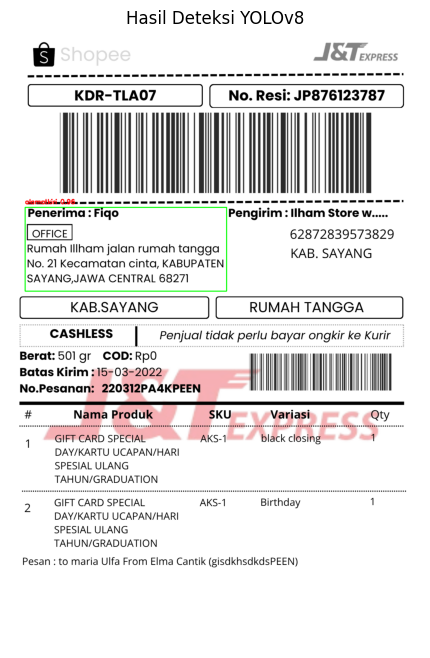

Jumlah box terdeteksi: 1


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO

# Path model dan gambar
model_path = r"C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset\result\train_alamat_preprocessed\weights\best.pt"
image_path = r"C:/Users/Taufiqur Rahman/OneDrive/Documents/label_alamat_dataset/label_alamat_dataset\images\train\1.png"

model = YOLO(model_path)
results = model.predict(source=image_path, save=False, show=False)
result = results[0]

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for box in result.boxes:
    x1, y1, x2, y2 = box.xyxy[0].int().tolist()
    label = model.names[int(box.cls)]
    conf = float(box.conf)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{label} {conf:.2f}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.title("Hasil Deteksi YOLOv8")
plt.show()
print("Jumlah box terdeteksi:", len(result.boxes))

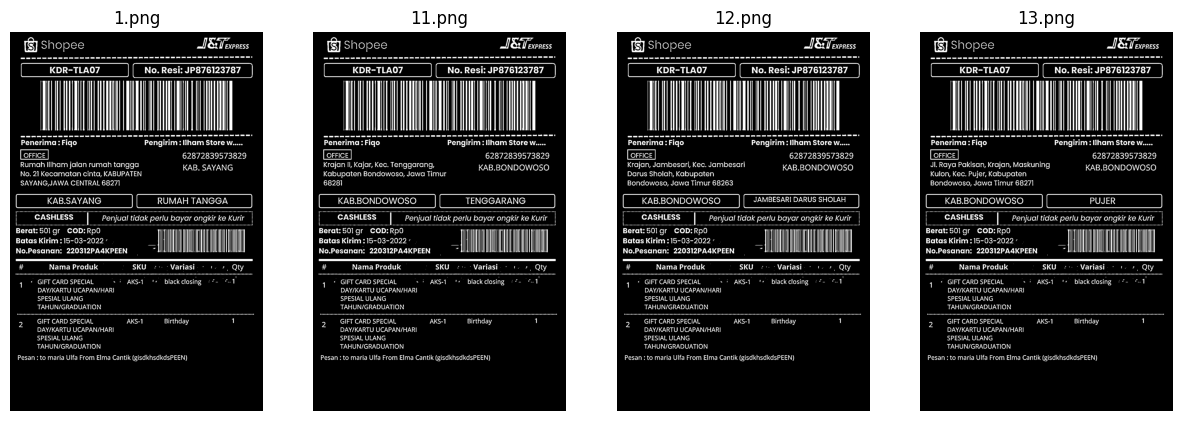

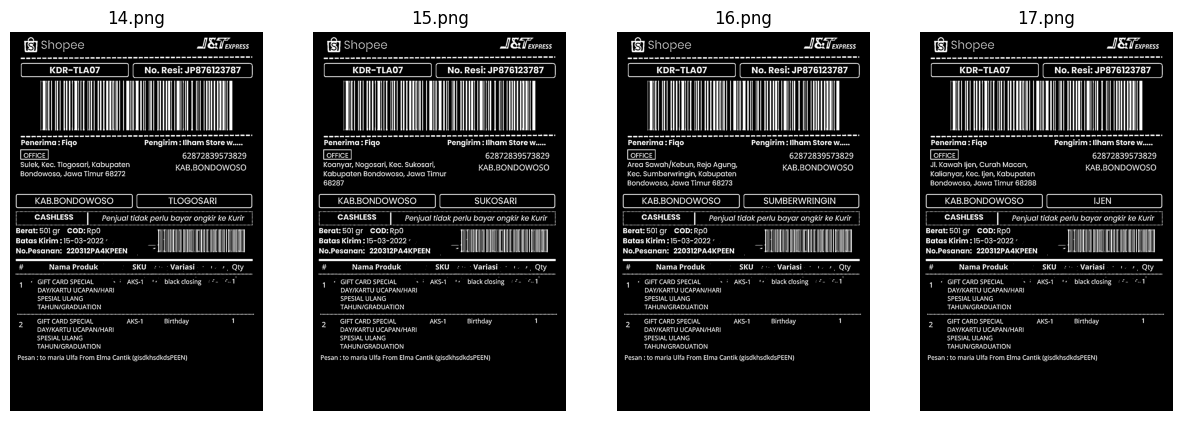

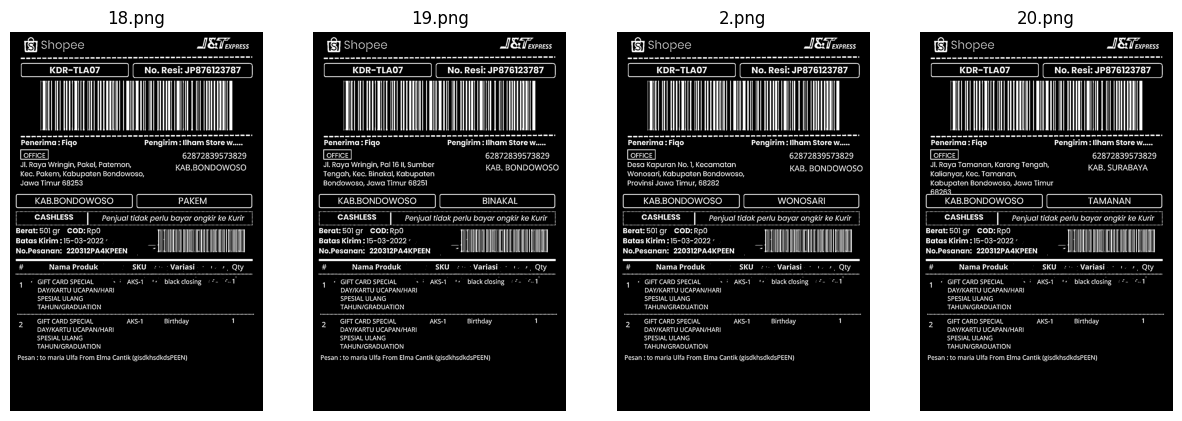

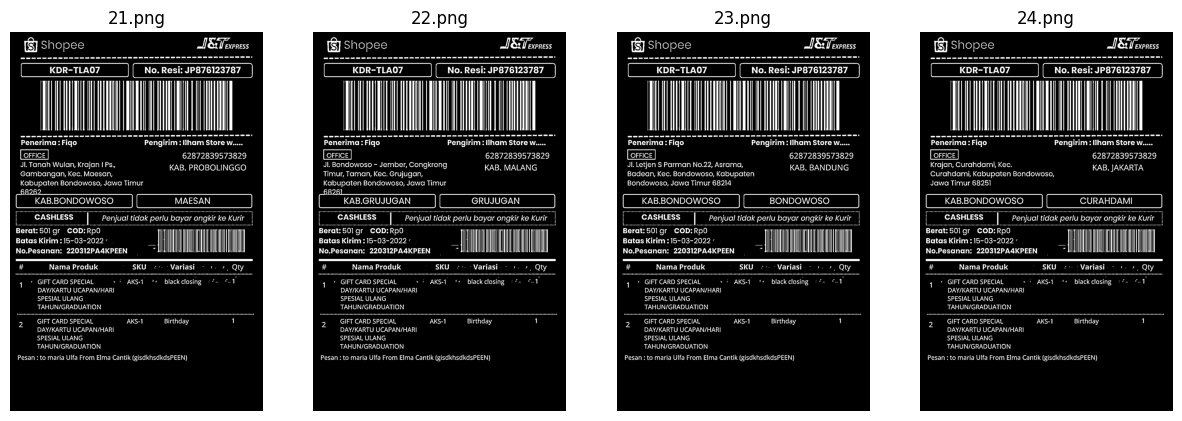

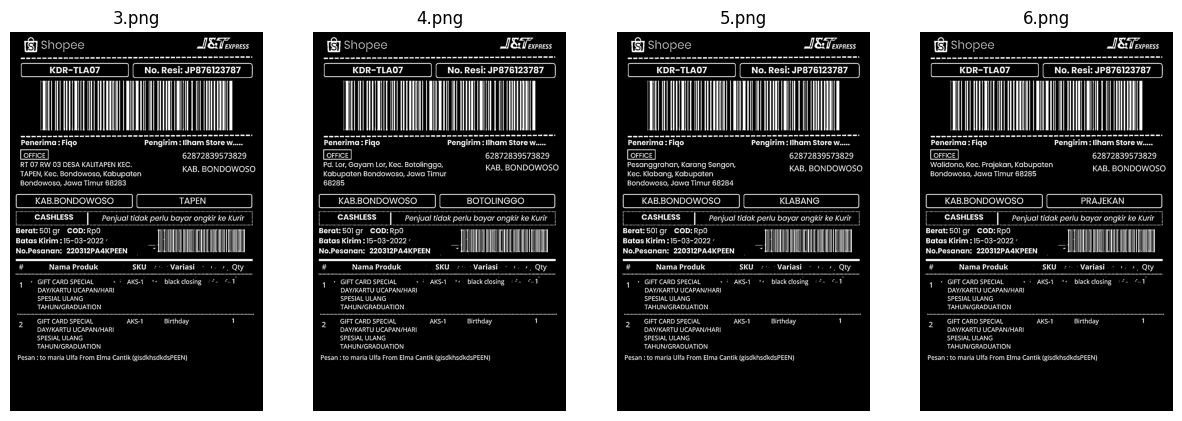

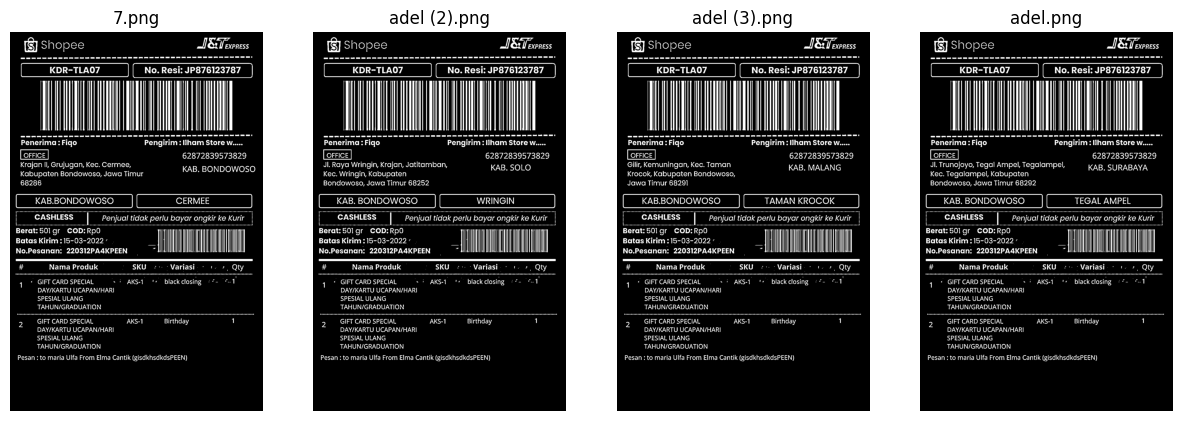

In [4]:
import cv2
import os
import matplotlib.pyplot as plt

input_folder = r'C:\Users\Taufiqur Rahman\OneDrive\Documents\label_alamat_dataset\label_alamat_dataset\images\train'

def preprocess_image_for_text(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        25, 15
    )
    return thresh 
   
  

# Ambil semua file gambar
images = []
filenames = []
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        path = os.path.join(input_folder, filename)
        processed = preprocess_image_for_text(path)
        if processed is not None:
            images.append(processed)
            filenames.append(filename)

# Tampilkan dalam grid
n = 4  # jumlah gambar per baris
for i in range(0, len(images), n):
    plt.figure(figsize=(15, 5))
    for j in range(n):
        if i+j < len(images):
            plt.subplot(1, n, j+1)
            plt.imshow(images[i+j], cmap='gray')
            plt.title(filenames[i+j])
            plt.axis('off')
    plt.show()
